# Inverse problems

In this demo, we'll revisit the Larsen Ice Shelf.
This time, we're going to estimate the fluidity coefficient $A$ in Glen's flow law

$$\dot\varepsilon = A\tau^3$$

from observational data.
In the previous demos, we've come up with some value of the fluidity coefficient and computed a velocity field by solving an elliptic partial differential equation.
The fluidity coefficient is roughly a known function of the ice temperature, together with some fudge factors for crystal fabric or large-scale damage, so we know an approximate range of values that it could take.
Nonetheless, we don't have large-scale measurements of the fluidity coefficient from remote sensing like we do for ice velocity and thickness.

Instead, we can try to come up with a value of $A$ that gives a velocity field closest to what we observed.
This idea can be turned into a constrained optimization problem.
The quantity we wish to optimize is the misfit between the computed velocity $u$ and the observed velocity $u^o$:

$$E(u) = \frac{1}{2}\int_\Omega\left(\frac{u - u^o}{\sigma}\right)^2dx,$$

where $\sigma$ are the standard deviations of the measurements.

One constraint is that the fluidity field has to be positive.
Inequality constraints can require substantially more sophisticated numerical methods.
To avoid this problem, we'll cheat our way out by reparameterizing $A$ in terms of a new variable $\theta$:

$$A = A_0e^\theta.$$

No matter the value of $\theta$, $A$ is always positive.
To make this change, we'll give the `IceShelf` object our own custom-made function for calculating the viscous part of the action functional, just like we did for the friction in the last demo.

In addition to minimizing the misfit, we also want to have a relatively smooth value of the parameter field $\theta$.
The regularization functional $R$ is included to penalize oscillations of size $\Theta$ over a given length scale $L$:

$$R(\theta) = \frac{L^2}{2\Theta^2}\int_\Omega|\nabla \theta|^2dx.$$

Finally, let $F(u, \theta)$ be the weak form of the shallow shelf equations, again using the new parameter $\theta$ instead of the fluidity $A$.
The physics constraint for our problem is that $F(u, \theta) = 0$.
We can enforce this constraint by introducing the Lagrange multiplier $\lambda$, in which case the combined objective functional is

$$J(u, \theta; \lambda) = E(u) + R(\theta) + \langle F(u, \theta), \lambda\rangle.$$

We can calculate the derivative of this functional with respect to $\theta$ by using the *adjoint method*.
We can then use a descent method to iterate towards a critical point, which is hopefully close to the true value of the fluidity coefficient.

### Input data

The input data are the same as from the previous demo of the Larsen Ice Shelf.

In [1]:
import subprocess
import geojson
import firedrake
import icepack

outline_filename = icepack.datasets.fetch_outline("larsen-2015")
with open(outline_filename, "r") as outline_file:
    outline = geojson.load(outline_file)

geometry = icepack.meshing.collection_to_geo(outline)
with open("larsen.geo", "w") as geo_file:
    geo_file.write(geometry.get_code())
    
command = "gmsh -2 -format msh2 -v 2 -o larsen.msh larsen.geo"
subprocess.run(command.split())
mesh = firedrake.Mesh("larsen.msh")

/home/firedrake/firedrake/lib/python3.10/site-packages/pytools/__init__.py:2484: UserWarning: unable to find git revision
  warn("unable to find git revision")


The code below is the same boilerplate as in the previous tutorial for plotting simulation results on top of the mosaic of Antarctica image.

In [2]:
import numpy as np
import rasterio
import icepack.plot

δ = 50e3
coords = np.array(list(geojson.utils.coords(outline)))
xmin, xmax = coords[:, 0].min() - δ, coords[:, 0].max() + δ
ymin, ymax = coords[:, 1].min() - δ, coords[:, 1].max() + δ

image_filename = icepack.datasets.fetch_mosaic_of_antarctica()
with rasterio.open(image_filename, "r") as image_file:
    transform = image_file.transform
    window = rasterio.windows.from_bounds(
        left=xmin,
        bottom=ymin,
        right=xmax,
        top=ymax,
        transform=transform,
    )
    image = image_file.read(indexes=1, window=window, masked=True)


def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots(*args, **kwargs)
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    kw = {
        "extent": (xmin, xmax, ymin, ymax),
        "cmap": "Greys_r",
        "vmin": 12e3,
        "vmax": 16.38e3,
    }
    try:
        axes.imshow(image, **kw)
    except AttributeError:
        for ax in axes:
            ax.imshow(image, **kw)

    return fig, axes

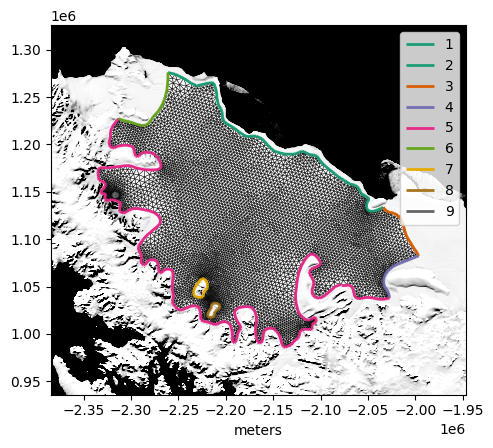

In [3]:
fig, axes = subplots()
axes.set_xlabel("meters")
kwargs = {
    "interior_kw": {"linewidth": 0.25},
    "boundary_kw": {"linewidth": 2},
}
firedrake.triplot(mesh, axes=axes, **kwargs)
axes.legend();

Just like in the 2nd demo, we'll apply the smoothing filter to the thickness, which is necessary to get a reasonable driving stress.

In [4]:
import xarray
from firedrake import assemble, Constant, inner, grad, dx

thickness_filename = icepack.datasets.fetch_bedmachine_antarctica()
thickness = xarray.open_dataset(thickness_filename)["thickness"]

Q = firedrake.FunctionSpace(mesh, family="CG", degree=2)
h0 = icepack.interpolate(thickness, Q)

h = h0.copy(deepcopy=True)
α = Constant(2e3)
J = 0.5 * ((h - h0) ** 2 + α ** 2 * inner(grad(h), grad(h))) * dx
F = firedrake.derivative(J, h)
firedrake.solve(F == 0, h)

In addition to the velocities themselves, we also need the estimates of the velocity measurement errors.
The fidelity of the measurements tells us how good a fit to the data we should expect.

In [5]:
velocity_filename = icepack.datasets.fetch_measures_antarctica()
velocity_dataset = xarray.open_dataset(velocity_filename)
vx = velocity_dataset["VX"]
vy = velocity_dataset["VY"]
errx = velocity_dataset["ERRX"]
erry = velocity_dataset["ERRY"]

V = firedrake.VectorFunctionSpace(mesh, family="CG", degree=2)
u_obs = icepack.interpolate((vx, vy), V)
σx = icepack.interpolate(errx, Q)
σy = icepack.interpolate(erry, Q)

Here we'll plot the velocity errors.
You can see from the stripey pattern that they depend on the particular swath from the observational platform.

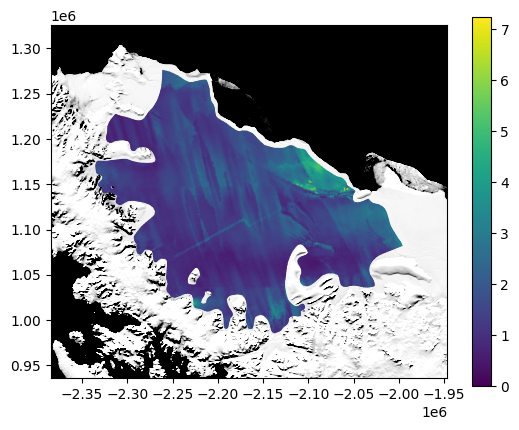

In [6]:
σ = firedrake.interpolate(firedrake.sqrt(σx**2 + σy**2), Q)
fig, axes = subplots()
colors = firedrake.tripcolor(σ, vmin=0, axes=axes)
fig.colorbar(colors);

We need to make an initial guess for the fluidity parameter.
In this case, we'll use the same value as in the second demo -- a constant fluidity assuming a temperature of -13C.

In [7]:
T = Constant(260)
A0 = icepack.rate_factor(T)


def viscosity(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    θ = kwargs["log_fluidity"]

    A = A0 * firedrake.exp(θ)
    return icepack.models.viscosity.viscosity_depth_averaged(
        velocity=u, thickness=h, fluidity=A
    )


model = icepack.models.IceShelf(viscosity=viscosity)
opts = {
    "dirichlet_ids": [2, 4, 5, 6, 7, 8, 9],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)

θ = firedrake.Function(Q)
u = solver.diagnostic_solve(
    velocity=u_obs,
    thickness=h,
    log_fluidity=θ,
)

Let's look at the observed ice velocity and the computed of the ice velocity starting from our assumption that the fluidity is constant in space.

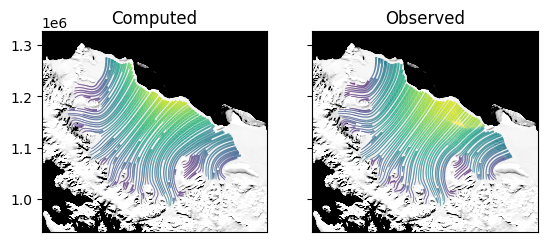

In [8]:
fig, axes = subplots(ncols=2, sharex=True, sharey=True)
for ax in axes:
    ax.get_xaxis().set_visible(False)
kwargs = {"resolution": 2500, "vmin": 0, "vmax": 750}
axes[0].set_title("Computed")
axes[1].set_title("Observed")
firedrake.streamplot(u, axes=axes[0], **kwargs)
firedrake.streamplot(u_obs, axes=axes[1], **kwargs);

There are a few obvious missing features in our initial computed solution.
For example, in this data, there's still a rift emanating from the Gipps Ice Rise.
(In 2017, that rift finished propagating all the way across the terminus and broke off [Iceberg A-68](https://en.wikipedia.org/wiki/Iceberg_A-68).)
Our initial computed velocity is smooth, but the observed velocity has a kink going across the rift.
The objective of the exercise that follows is to compute a fluidity field that will reproduce features like the kink in the velocity pattern that emerges as a result of features like rifts.

### Inferring the fluidity

There are four parts that go into an inverse problem:

* a physics model
* an initial guess for the parameter and state
* an error metric
* a smoothness metric

We already have the physics model and some initial guesses.
The physics are wrapped up in the Python function `simulation` defined below; we'll pass this function when we create the inverse problem.

In [9]:
def simulation(θ):
    return solver.diagnostic_solve(
        velocity=u_obs,
        thickness=h,
        log_fluidity=θ,
    )

Since the ice shelf is so large, we're going to want to scale some of our output quantities of interest by the area of the shelf.
This will make everything into nice dimensionless numbers, rather than on the order of $10{}^{10}$.

In [10]:
area = Constant(assemble(Constant(1.0) * dx(mesh)))

The next step is to write a pair of Python functions that will create the model-data misfit functional and the regularization functional.

In [11]:
def loss_functional(u):
    δu = u - u_obs
    return 0.5 / area * ((δu[0] / σx)**2 + (δu[1] / σy)**2) * dx


def regularization(θ):
    Θ = Constant(1.)
    L = Constant(7.5e3)
    return 0.5 / area * (L / Θ)**2 * inner(grad(θ), grad(θ)) * dx

Now we'll create create a `StatisticsProblem` object.
To specify the problem, we need to give it:

1. a procedure `simulation` for running the simulation, 
2. a procedure `loss_functional` for evaluating how good our computed state fits the observations,
3. a procedure `regularization` for evaluating how simple or complex our guess for the parameters is, and finally
4. an initial guess for the unknown parameters.

The statistics problem class uses the keyword argument "controls" here to reflect the generality of the types of fields that we might be solving for, which might not be "parameters" in the strictest sense of the word for some problems.

In [12]:
from icepack.statistics import (
    StatisticsProblem,
    MaximumProbabilityEstimator,
)

problem = StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    controls=θ,
)

Once we've created the problem, we then create a solver object that will iteratively search for a good value of the parameters.
The inverse solver has lots of moving parts, all of which are wrapped up in the class `MaximumProbabilityEstimator`.
This class wraps up functionality for solving nonlinear optimization problems in a way that (hopefully) insulates you from having to know too much about the low-level details.
In this case, it'll call out to the [Rapid Optimization Library](https://trilinos.github.io/rol.html) (ROL).
The algorithm takes about 30-45 minutes to run.
Now would be the time to put on a fresh pot of coffee.

In [13]:
estimator = MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-1,
    max_iterations=50,
)
θ = estimator.solve()


Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     1.889343e+03   3.155963e-02                  6.678472e+04   
  1     6.465015e+02   1.940460e-02   6.678472e+04   1.669618e+05   3         2         0         2         3         
  2     6.465015e+02   1.940460e-02   1.669618e+05   1.043511e+04   4         2         2         3         2         
  3     4.715252e+02   1.421254e-02   1.043511e+04   2.608778e+04   5         3         0         1         3         
  4     2.876383e+02   8.217907e-03   2.608778e+04   2.608778e+04   6         4         0         1         3         
  5     1.796262e+02   3.052547e-03   2.608778e+04   6.521945e+04   7         5         0         2         3         
  6     1.189371e+02   5.663122e-03   6.521945e+04   6.521945e+04   8         6         0         4         3         
  7     6.480015e+01   2.084243e-03   6.521945e+04   6.521945e+0

At each iteration, ROL will print out some information about the magnitude of the objective functional and its gradient so you can see how fast these quantities are decreasing.
Other methods might take more or less iterations to reach the same agreement with the data.
We've told the method to stop iterating once the norm of the gradient is less than $10^{-4}$, the norm of the step from one iteration to the next is less than $10^{-1}$, or if it takes more than 50 iterations.
In this case, it reached the gradient tolerance first.
It's a good idea to experiment with these tolerances to make sure that you've actually reached convergence.

### Analysis

Now that we're done, we'll want to do some post-processing and analysis on the fluidity parameter that we inferred.
First, let's plot the parameter values.

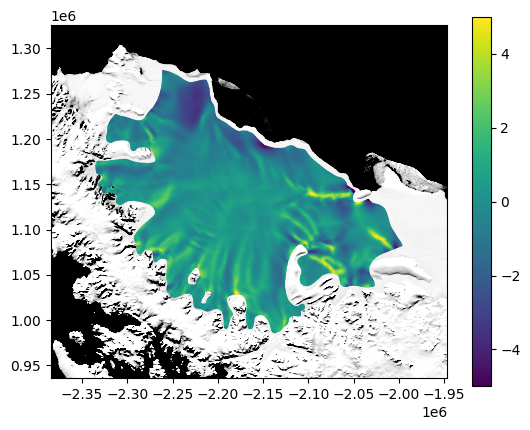

In [14]:
fig, axes = subplots()
colors = firedrake.tripcolor(θ, vmin=-5, vmax=+5, axes=axes)
fig.colorbar(colors);

The fluidity is much higher around areas of heavy crevassing, such as the rift opening from the Gipps Ice Rise and the area flowing into it.
Additionally, several areas downstream of the inlets have much higher fluidity, and these might indicate the formation of marine ice.

The fluidity is substantially lower around the upper left edge of the ice shelf.
Some of the ice might actually be grounded here, in which case the resulting basal drag would tend to reduce the extensional strain of the glacier.
However, since the only tunable variable for explaining the observed velocities is the fluidity, the algorithm will erroneously converge on whatever value of the fluidity can reproduce the observed values.
In this case, the result is a very low value of $A$, but for other problems the bias can go in the other direction.

To see how well the parameters fit the data, let's look at the weighted difference between the computed and observed velocities.

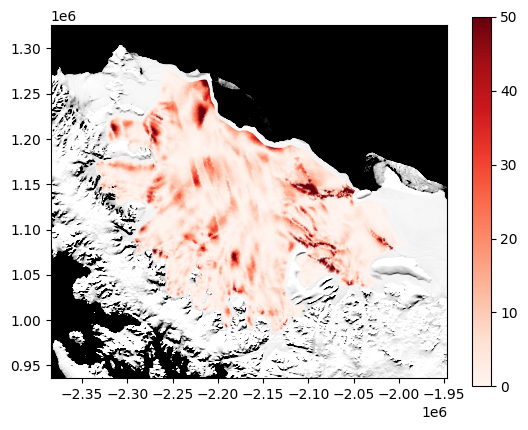

In [15]:
u = simulation(θ)
fig, axes = subplots()
δu = firedrake.interpolate((u - u_obs)**2 / (2 * σ**2), Q)
colors = firedrake.tripcolor(
    δu, vmin=0, vmax=50, cmap="Reds", axes=axes
)
fig.colorbar(colors);

The computed ice velocity is mostly similar to observations aside from a few blips.
The most widespread departures from observations occur around the rifts that flow into the Gipps Ice Rise.
We regularized the problem by looking only for smooth values of the fluidity parameter.
As a consequence, we won't be able to see sharp changes that might result from features like crevasses or rifts.
We might instead try to use the total variation functional

$$R(\theta) = L\int_\Omega|\nabla\theta|dx$$

if we were interested in features like this.

Finally, let's try and see how much the inferred parameter departed from our naive initial guess.

In [16]:
print(icepack.norm(θ) / np.sqrt(float(area)))
print(assemble(loss_functional(u) + regularization(θ)))

1.159558192406269
18.684347396179255


The model-data misfit has been reduced by two orders of mangitude through the optimization procedure, and our final approximation departs quite substantially from the initial guess.
This suggests that data assimilation does give a substantial benefit over an ad-hoc approach like picking a sensible constant value.

### Conclusion

In this demo, we've shown how to back out the fluidity of an ice shelf from remote sensing observations.
We could then use this value, together with a description of how the fluidity evolves, to initialize a prognostic model of the ice shelf.
For example, we might assume that the fluidity is a function of ice temperature and damage.
The evolution equations for these fields are fairly simple hyperbolic PDE for which we can write solvers using firedrake.

The value of the fluidity that we obtained is not at all spatially homogeneous.
Unless we were very clever, we probably couldn't have come up with some way to parameterize it to get a reasonable guess.

We would expect from statistical estimation theory that the value of the misfit functional divided by the shelf area will be around 1.
(A sum of squares of normal random variables has a $\chi^2$ distribution, which has mean 1, there are two components of the velocity vector, and we divide by 2 at the end.)
The misfit we obtained once the algorithm has converged is much larger than 1.
Why might this happen?

1. We made a poor choice of regularization parameter; the solution is too smooth to fit the data.
2. The regularization parameter is fine, but the error estimates $\sigma$ are wrong.
3. The standard deviations $\sigma$ of the error estimates are correct, but the error distribution is non-normal and has heavier tails.
4. We don't have a good way to also account for thickness errors, which are substantial.
5. The ice shelf is actually grounded on some isolated pinning points or ice rises and we didn't add any basal drag.
6. The model physics don't adequately account for the effects of rifts and crevasses.
7. The numerical optimization algorithm is implemented incorrectly.

Failure modes 1 happens because we don't have the right prior distribution, while modes 2, 3, and 4 occur because we don't have the correct observational likelihood.
Modes 5 and 6 are more insidious types of failure.
In this case, the physics model doesn't actually describe the true behavior of the system.
This might mean that the model cannot reproduce the observations with *any* value of the input data.
That kind of failure is difficult to miss.
But some wrong physics models -- those that are [controllable](https://en.wikipedia.org/wiki/Controllability) as a function of the input parameters -- might still be able to reproduce the observations.
The catch is that they will "explain" the data however they can, even if the reasons are wrong!
Diagnosing this type of failure is arguably the most difficult.
Last but not least is human error in implementing the optimization algorithms.
These kinds of failures should be caught through testing on synthetic problems.